### About 

"""
#++++++++++++++++++++++++++++++++++++++++++++++

    Project: Part of final project for Georgia Tech Institute of Technology course DL, CS 7643. 

    Totality of this code is non-proprietary and may be used at will. 

#++++++++++++++++++++++++++++++++++++++++++++++


Description: 

@brief a notebook defining initial prototyping of model definition, dataset object instantiator, model trainer, and actual model training and evaluation.

@author: Greg Zdor (gzdor@icloud.com)

@date Date_Of_Creation: 3/25/2023 

@date Last_Modification 3/25/2023 

No Copyright - use at will

"""

In [1]:
# Imports 

# System level imports 
import os 
import sys
import time 
import yaml
from datetime import datetime

# ML and data science imports 
import torch
import torchinfo
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

# Add local source files to namespace 
sys.path.append('../../')

# Local imports
from pkgs.utils.plotting_utils import * 
from pkgs.data_loaders.memory_mapper import load_parameters, SigMFDataMMapper
from pkgs.data_loaders.sigmf_dataset import SigMFDataMMapper, SigMFDataset, IQDataAugmenter

now = datetime.now()
print(f'\n\nLast time this cell was run was \n\n  {now.strftime("%d/%m/%Y %H:%M:%S")}\n\n')




Last time this cell was run was 

  26/03/2023 00:17:15




User, update the following path according to your repo  location

In [2]:
repo_root_path = r"/mnt/c/Users/gregt/Desktop/academic_life/ga_tech_cs7643_deep_learning/Radio_Frequency_Fingerprinting_802.11/"

#### Define dataset

In [3]:
# Set up dataset object
dataset_config_path = os.path.join(repo_root_path, "src", "pkgs", "data_loaders", "memory_mapper.yml")
with open(dataset_config_path, "rt") as h_file:
    parameters = yaml.safe_load(h_file)


memmapper = SigMFDataMMapper(parameters)
dataset = SigMFDataset("training", memmapper, transform = IQDataAugmenter())

#### Visualize example model input tensor features from dataset



Creating time domain plot.




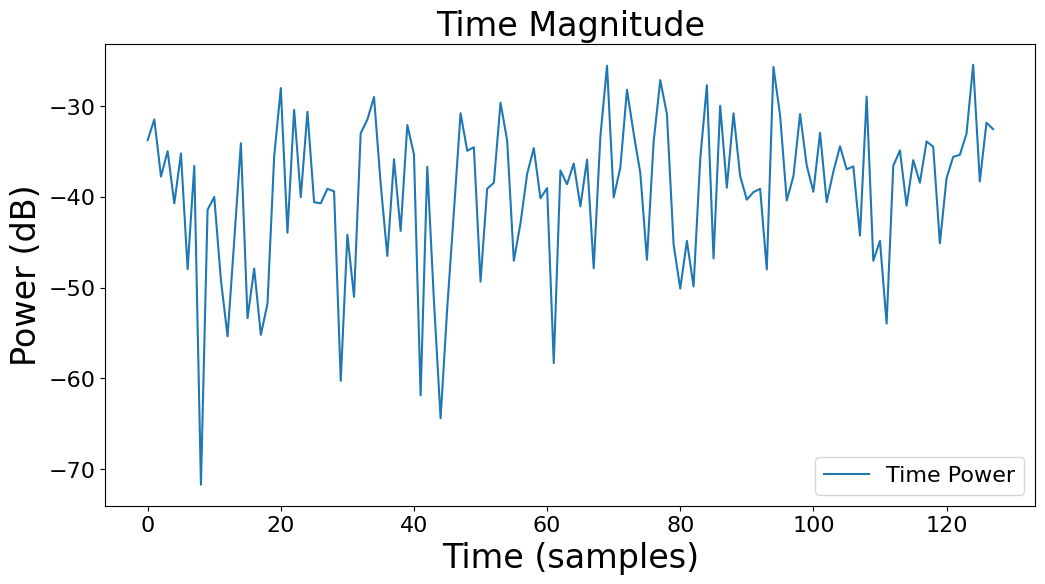



Creating frequency domain plot.




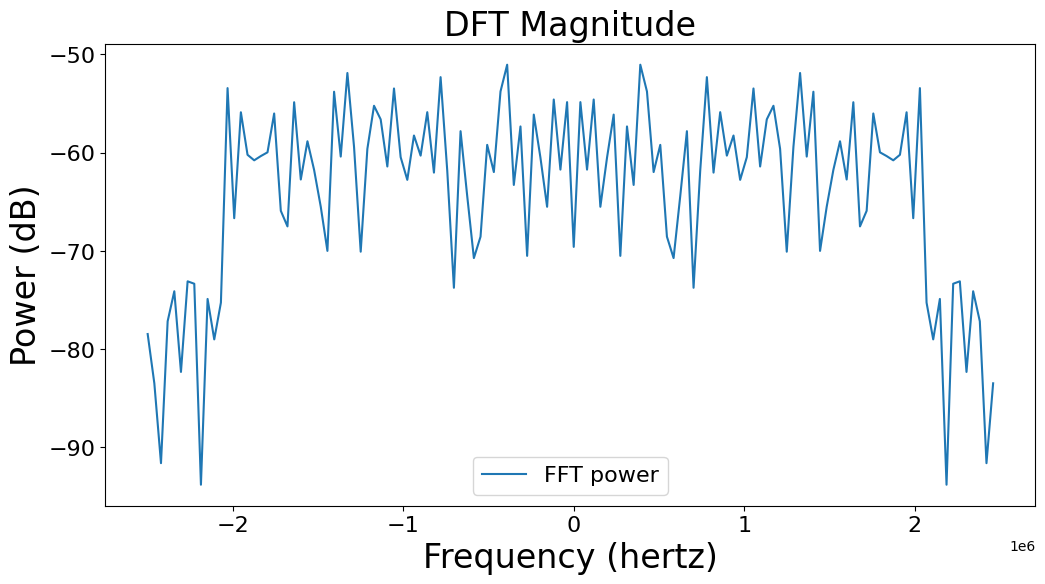

In [4]:
# Visualize samples from dataset 
real_samples  = dataset[0][0][0].numpy() 
imag_samples  = dataset[0][0][1].numpy()
iq = dataset[0][0][0].numpy()

create_time_domain_plot(iq)

create_dft(iq, 128, 5e6)

#### Create PyTorch Lightning data module 

In [11]:
# Create Pytorch Lightning module for dataset 

class LightningOracleDataset(pl.LightningDataModule): 

    def __init__(self): 
        """
        @brief constructor 

        @type parameters dict 
        @param parameters the input parameters from the mem mapper yaml config file.
        """

        super(LightningOracleDataset, self).__init__() 

        self.mmapper = SigMFDataMMapper(parameters)
        self.batch_size = parameters.get("batch_size", 1024)
        self.num_workers = parameters.get("num_workers", 0)


    def setup(self, stage: str):

        self.sigmf_training =\
            SigMFDataset("training",
                         self.mmapper,
                         IQDataAugmenter())
        
        self.sigmf_validation =\
            SigMFDataset("validation", self.mmapper)
        
        self.sigmf_test = SigMFDataset("test", self.mmapper)


    def train_dataloader(self):
        return DataLoader(self.sigmf_training,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.sigmf_validation,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.sigmf_test,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)


#### Define neural network

In [56]:
cnn_classifier_cfg = {

    "num_classes"                 :        16, 
    "vector_len"                  :        128, # length in time of input signal sequence
    "n_features"                  :        2, # I and Q signal dimensions 
    "max_pool_kernel_size"        :        2, 
    "max_pool_stride"             :        1,
    "n_conv_layers"               :        2,
    "conv_layers"                 :  
        {
            "conv_1_n_filters"    :        128, 
            "conv_1_n_stride"     :        1, 
            "conv_1_kernal_size"  :        3,
            "conv_1_padding"      :        1, 
            "conv_2_n_filters"    :        16, 
            "conv_2_n_stride"     :        1, 
            "conv_2_kernal_size"  :        3,
            "conv_2_padding"      :        1, 
        }, 
    "conv_activations"            :        "Relu",
    "n_dense_layers"              :        2, 
    "dense_layers"                :
        {
            "dense_1_hidden_size" :        128, 
            "dense_2_hidden_size" :        128, 
            "dense_1_dropout"     :        0.2, 
            "dense_2_dropout"     :        0.2, 
        },
    "last_dense_layer_size"       :        64,
}

In [65]:
# Plain PyTorch model 

class CNNClassifier(nn.Module):
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(CNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg

    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities

In [66]:
# View model s
batch_size = 16
cnn_model = CNNClassifier(cnn_classifier_cfg)

input_tensor_size = (batch_size, 2, 128)
model_info = torchinfo.summary(cnn_model, input_size = input_tensor_size)
print(f'\n\nModel summary\n\n{model_info}\n\n')

# Pass in dummy data into model 
x = torch.rand(1024, 2, 128)
cnn_model.forward(x)



Model summary

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [16, 16]                  --
├─Conv1d: 1-1                            [16, 128, 128]            896
├─ReLU: 1-2                              [16, 128, 128]            --
├─MaxPool1d: 1-3                         [16, 128, 127]            --
├─Conv1d: 1-4                            [16, 16, 127]             6,160
├─ReLU: 1-5                              [16, 16, 127]             --
├─MaxPool1d: 1-6                         [16, 16, 126]             --
├─Linear: 1-7                            [16, 128]                 258,176
├─Dropout: 1-8                           [16, 128]                 --
├─Linear: 1-9                            [16, 64]                  8,256
├─Dropout: 1-10                          [16, 64]                  --
├─Linear: 1-11                           [16, 16]                  1,040
Total params: 274,528
Trainable params: 274,528
Non-t

tensor([[ 0.1119,  0.0365,  0.0523,  ..., -0.0359,  0.0068,  0.0244],
        [ 0.1238,  0.0405,  0.0400,  ..., -0.0021, -0.0368,  0.0131],
        [ 0.1648,  0.0666,  0.0433,  ..., -0.0475, -0.0186,  0.0289],
        ...,
        [ 0.1194,  0.0420,  0.0106,  ..., -0.0437, -0.0168,  0.0107],
        [ 0.1563,  0.0501,  0.0248,  ...,  0.0179, -0.0450,  0.0303],
        [ 0.1749,  0.0593,  0.0427,  ..., -0.0355, -0.0213,  0.0762]],
       grad_fn=<AddmmBackward0>)

In [63]:
# Wrap model in Lightning module 

class LightningCNNClassifier(pl.LightningModule): 
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(LightningCNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg


    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities


    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr  = 1e-3)
        return optimizer 
    

    def cross_entropy_loss(self, logits, labels): 
        return torch.nn.functional.nll_loss(logits, labels)


    def training_step(self, train_batch, batch_idx):
        print(f'training data tensor shape is:  {x.shape}\n')
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)


#### Execute training

In [64]:
# Train model

data_module = LightningOracleDataset()

model = LightningCNNClassifier(cnn_classifier_cfg)

trainer = pl.Trainer(
    enable_progress_bar = True, 
    enable_checkpointing = True, 
    enable_model_summary = True,
    callbacks = [pl.callbacks.ModelCheckpoint(monitor = "val_loss", mode = "min")], # ckpt resource:  https://devblog.pytorchlightning.ai/introducing-multiple-modelcheckpoint-callbacks-e4bc13f9c185 
    max_epochs = 100, 
) 

trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params
-------------------------------------------------
0 | conv_1             | Conv1d    | 896   
1 | conv_2             | Conv1d    | 6.2 K 
2 | conv_activation    | ReLU      | 0     
3 | maxpool            | MaxPool1d | 0     
4 | dense_1            | Linear    | 258 K 
5 | dense_2            | Linear    | 8.3 K 
6 | dense_drop_1       | Dropout   | 0     
7 | dense_drop_2       | Dropout   | 0     
8 | output_dense_layer | Linear    | 1.0 K 
-------------------------------------------------
274 K     Trainable params
0         Non-trainable params
274 K     Total params
1.098     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

#### Evaluate model

In [ ]:
# Calculate average accuracy, confusion matrix